# Final Project

## Predict whether a mammogram mass is benign or malignant

We'll be using the "mammographic masses" public dataset from the UCI repository (source: https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass)

This data contains 961 instances of masses detected in mammograms, and contains the following attributes:


   1. BI-RADS assessment: 1 to 5 (ordinal)  
   2. Age: patient's age in years (integer)
   3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
   4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
   5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
   6. Severity: benign=0 or malignant=1 (binominal)
   
BI-RADS is an assesment of how confident the severity classification is; it is not a "predictive" attribute and so we will discard it. The age, shape, margin, and density attributes are the features that we will build our model with, and "severity" is the classification we will attempt to predict based on those attributes.

Although "shape" and "margin" are nominal data types, which sklearn typically doesn't deal with well, they are close enough to ordinal that we shouldn't just discard them. The "shape" for example is ordered increasingly from round to irregular.

A lot of unnecessary anguish and surgery arises from false positives arising from mammogram results. If we can build a better way to interpret them through supervised machine learning, it could improve a lot of lives.

## Your assignment

Apply several different supervised machine learning techniques to this data set, and see which one yields the highest accuracy as measured with K-Fold cross validation (K=10). Apply:

* Decision tree
* Random forest
* KNN
* Naive Bayes
* SVM
* Logistic Regression
* And, as a bonus challenge, a neural network using Keras.

The data needs to be cleaned; many rows contain missing data, and there may be erroneous data identifiable as outliers as well.

Remember some techniques such as SVM also require the input data to be normalized first.

Many techniques also have "hyperparameters" that need to be tuned. Once you identify a promising approach, see if you can make it even better by tuning its hyperparameters.

## Let's begin: prepare your data

Start by importing the mammographic_masses.data.txt file into a Pandas dataframe (hint: use read_csv) and take a look at it.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
mass = pd.read_csv('mammographic_masses.data.txt')

In [3]:
mass.head(3)

,5,67,3,5.1,3.1,1
0,4,43,1,1,?,1
1,5,58,4,5,3,1
2,4,28,1,1,3,0


In [4]:
mass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   5       960 non-null    object
 1   67      960 non-null    object
 2   3       960 non-null    object
 3   5.1     960 non-null    object
 4   3.1     960 non-null    object
 5   1       960 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 45.1+ KB


Make sure you use the optional parmaters in read_csv to convert missing data (indicated by a ?) into NaN, and to add the appropriate column names (BI_RADS, age, shape, margin, density, and severity):

In [5]:
mass = pd.read_csv('mammographic_masses.data.txt',
                   na_values = ['?'],
                   names = ['BI_RADS','age','shape','margin','density','severity'])

Evaluate whether the data needs cleaning; your model is only as good as the data it's given. Hint: use describe() on the dataframe.

In [6]:
mass.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
BI_RADS,959.0,4.348279,1.783031,0.0,4.0,4.0,5.0,55.0
age,956.0,55.487448,14.480131,18.0,45.0,57.0,66.0,96.0
shape,930.0,2.721505,1.242792,1.0,2.0,3.0,4.0,4.0
margin,913.0,2.796276,1.566546,1.0,1.0,3.0,4.0,5.0
density,885.0,2.910734,0.380444,1.0,3.0,3.0,3.0,4.0
severity,961.0,0.463059,0.498893,0.0,0.0,0.0,1.0,1.0


In [7]:
mass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   BI_RADS   959 non-null    float64
 1   age       956 non-null    float64
 2   shape     930 non-null    float64
 3   margin    913 non-null    float64
 4   density   885 non-null    float64
 5   severity  961 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 45.2 KB


In [8]:
mass['severity'].value_counts()

0    516
1    445
Name: severity, dtype: int64

There are quite a few missing values in the data set. Before we just drop every row that's missing data, let's make sure we don't bias our data in doing so. Does there appear to be any sort of correlation to what sort of data has missing fields? If there were, we'd have to try and go back and fill that data in.

In [9]:
def percent_missing(df):
    percent_nan = 100 * df.isnull().sum()/len(df)
    percent_nan = percent_nan[percent_nan>0].sort_values()
    return percent_nan

Text(0, 0.5, '% missing')

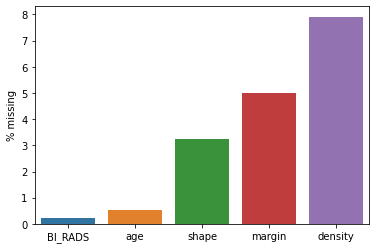

In [10]:
percent_nan = percent_missing(mass)
sns.barplot(x=percent_nan.index,y=percent_nan)
plt.ylabel('% missing')

In [11]:
mass[(mass['age'].isnull())|
     (mass['shape'].isnull()) |
     (mass['margin'].isnull()) |
     (mass['density'].isnull())]

,BI_RADS,age,shape,margin,density,severity
1,4.0,43.0,1.0,1.0,NaN,1
4,5.0,74.0,1.0,5.0,NaN,1
5,4.0,65.0,1.0,NaN,3.0,0
6,4.0,70.0,NaN,NaN,3.0,0
7,5.0,42.0,1.0,NaN,3.0,0
...,...,...,...,...,...,...
778,4.0,60.0,NaN,4.0,3.0,0
819,4.0,35.0,3.0,NaN,2.0,0
824,6.0,40.0,NaN,3.0,4.0,1
884,5.0,NaN,4.0,4.0,3.0,1


In [12]:
mass.isnull().sum()

BI_RADS      2
age          5
shape       31
margin      48
density     76
severity     0
dtype: int64

If the missing data seems randomly distributed, go ahead and drop rows with missing data. Hint: use dropna().

In [13]:
mass.dropna(inplace=True)

In [14]:
mass.isnull().sum()

BI_RADS     0
age         0
shape       0
margin      0
density     0
severity    0
dtype: int64

Next you'll need to convert the Pandas dataframes into numpy arrays that can be used by scikit_learn. Create an array that extracts only the feature data we want to work with (age, shape, margin, and density) and another array that contains the classes (severity). You'll also need an array of the feature name labels.

In [15]:
X = mass.drop(['severity','BI_RADS'],axis=1)
y = mass['severity']

Some of our models require the input data to be normalized, so go ahead and normalize the attribute data. Hint: use preprocessing.StandardScaler().

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

## Decision Trees

Before moving to K-Fold cross validation and random forests, start by creating a single train/test split of our data. Set aside 75% for training, and 25% for testing.

In [18]:
# see above

Now create a DecisionTreeClassifier and fit it to your training data.

In [19]:
from sklearn.tree import DecisionTreeClassifier

In [20]:
dtc = DecisionTreeClassifier(random_state=101)
dtc.fit(scaled_X_train,y_train)

DecisionTreeClassifier(random_state=101)

Display the resulting decision tree.

In [21]:
dtc_pred = dtc.predict(scaled_X_test)

Measure the accuracy of the resulting decision tree model using your test data.

In [22]:
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix,accuracy_score

In [23]:
confusion_matrix(y_test,dtc_pred)

array([[81, 27],
       [31, 69]])

/Users/tian/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


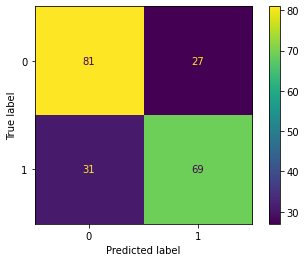

In [24]:
plot_confusion_matrix(dtc,scaled_X_test,y_test)

In [25]:
print(classification_report(y_test,dtc_pred))

              precision    recall  f1-score   support

           0       0.72      0.75      0.74       108
           1       0.72      0.69      0.70       100

    accuracy                           0.72       208
   macro avg       0.72      0.72      0.72       208
weighted avg       0.72      0.72      0.72       208



In [26]:
accuracy_score(y_test,dtc_pred)

0.7211538461538461

In [27]:
dtc.feature_importances_

array([0.36889498, 0.09596899, 0.50018325, 0.03495278])

Now instead of a single train/test split, use K-Fold cross validation to get a better measure of your model's accuracy (K=10). Hint: use model_selection.cross_val_score

In [28]:
from sklearn.model_selection import cross_val_score

In [29]:
dtc_cv_scores = cross_val_score(dtc,scaled_X_train,y_train,scoring='accuracy',cv=10)

In [30]:
dtc_cv_scores.mean()

0.7266769073220687

Now try a RandomForestClassifier instead. Does it perform better?

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
rfc = RandomForestClassifier(n_estimators=64,max_features='auto',random_state=101)
rfc_cv_scores = cross_val_score(rfc,scaled_X_train,y_train,scoring='accuracy',cv=10)
rfc_cv_scores.mean()

0.7378648233486944

In [33]:
rfc.fit(scaled_X_train,y_train)

RandomForestClassifier(n_estimators=64, random_state=101)

In [34]:
accuracy_score(y_test,rfc.predict(scaled_X_test))

0.7836538461538461

Answer:

Yes, RandomFroestClassifier performs better. We may try to use grid search to find out the a combination of hyperparameters to help improve the accuracy further.

In [35]:
from sklearn.model_selection import GridSearchCV

In [36]:
n_estimators=[64,100,128,200]
max_features= [2,3,4]
bootstrap = [True,False]

In [37]:
param_grid = {'n_estimators':n_estimators,
             'max_features':max_features,
             'bootstrap':bootstrap} 

In [38]:
rfc = RandomForestClassifier()
rfc_grid = GridSearchCV(rfc,param_grid,cv=10)
rfc_grid.fit(scaled_X_train,y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False], 'max_features': [2, 3, 4],
                         'n_estimators': [64, 100, 128, 200]})

In [39]:
rfc_grid.best_params_

{'bootstrap': True, 'max_features': 2, 'n_estimators': 64}

In [40]:
rfc_grid_pred = rfc_grid.predict(scaled_X_test)

In [41]:
accuracy_score(y_test,rfc_grid_pred)

0.7836538461538461

## SVM

Next try using svm.SVC with a linear kernel. How does it compare to the decision tree?

In [42]:
from sklearn.svm import SVC

In [43]:
svc = SVC(kernel='linear',C=1.0)
svc_cv_scores = cross_val_score(svc,scaled_X_train,y_train,scoring='accuracy',cv=10)
svc_cv_scores.mean()

0.773399897593446

In [44]:
svc.fit(scaled_X_train,y_train)

SVC(kernel='linear')

In [45]:
accuracy_score(y_test,svc.predict(scaled_X_test))

0.8413461538461539

Answer:

SupportVectorMachines has better performance than the decision tree. 

## KNN
How about K-Nearest-Neighbors? Hint: use neighbors.KNeighborsClassifier - it's a lot easier than implementing KNN from scratch like we did earlier in the course. Start with a K of 10. K is an example of a hyperparameter - a parameter on the model itself which may need to be tuned for best results on your particular data set.

In [46]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

Choosing K is tricky, so we can't discard KNN until we've tried different values of K. Write a for loop to run KNN with K values ranging from 1 to 50 and see if K makes a substantial difference. Make a note of the best performance you could get out of KNN.

In [47]:
k_values = list(range(1,51))
param_grid = {'knn__n_neighbors':k_values}

operations = [('knn',knn)]

from sklearn.pipeline import Pipeline
pipe = Pipeline(operations)

In [48]:
knn_grid = GridSearchCV(pipe,param_grid,cv=10,scoring='accuracy')

In [49]:
knn_grid.fit(scaled_X_train,y_train)

GridSearchCV(cv=10, estimator=Pipeline(steps=[('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29, 30, ...]},
             scoring='accuracy')

In [50]:
knn_grid.best_estimator_

Pipeline(steps=[('knn', KNeighborsClassifier(n_neighbors=15))])

In [51]:
knn_grid.cv_results_['mean_test_score']

array([0.71374808, 0.70888377, 0.76351767, 0.74751664, 0.7796723 ,
       0.76676907, 0.7780594 , 0.77647209, 0.77322069, 0.77007168,
       0.77329749, 0.76367127, 0.78448541, 0.7781362 , 0.79096262,
       0.77324629, 0.78937532, 0.78773682, 0.78294931, 0.7796979 ,
       0.78771121, 0.77647209, 0.77168459, 0.76843318, 0.7781106 ,
       0.7781106 , 0.7797235 , 0.77168459, 0.7765489 , 0.7764977 ,
       0.77332309, 0.77332309, 0.77334869, 0.77012289, 0.77176139,
       0.76853559, 0.7766001 , 0.7781874 , 0.77980031, 0.77980031,
       0.77980031, 0.7781874 , 0.78783922, 0.78622632, 0.78783922,
       0.78463902, 0.78622632, 0.78945212, 0.78461342, 0.78466462])

Text(0, 0.5, 'Accuracy')

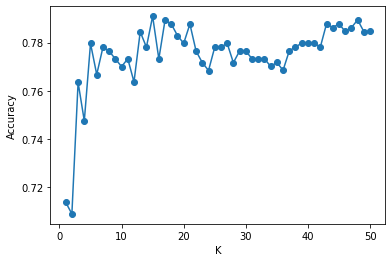

In [52]:
plt.figure(figsize=(6,4))
plt.plot(range(1,51),knn_grid.cv_results_['mean_test_score'],marker='o')
plt.xlabel('K')
plt.ylabel('Accuracy')

In [53]:
knn_grid_pred = knn_grid.predict(scaled_X_test)

In [54]:
accuracy_score(y_test,knn_grid_pred)

0.8269230769230769

## Naive Bayes

Now try naive_bayes.MultinomialNB. How does its accuracy stack up? Hint: you'll need to use MinMaxScaler to get the features in the range MultinomialNB requires.

In [55]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

In [56]:
scaler = MinMaxScaler()

minmax_X_train = scaler.fit_transform(X_train)
minmax_X_test = scaler.transform(X_test)

mnb = MultinomialNB()
mnb_cv_scores = cross_val_score(mnb,minmax_X_train,y_train,cv=10)
mnb_cv_scores.mean()


0.762058371735791

In [57]:
mnb.fit(minmax_X_train,y_train)

MultinomialNB()

In [58]:
accuracy_score(y_test,mnb.predict(minmax_X_test))

0.8269230769230769

## Revisiting SVM

svm.SVC may perform differently with different kernels. The choice of kernel is an example of a "hyperparamter." Try the rbf, sigmoid, and poly kernels and see what the best-performing kernel is. Do we have a new winner?

In [59]:
svc = SVC()
param_grid = {'kernel':['linear','rbf','sigmoid','poly'],
             'C':[0.01,0.1,0.5,1,5,10]}

svc_grid = GridSearchCV(svc,param_grid)

In [60]:
svc_grid.fit(scaled_X_train,y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 0.5, 1, 5, 10],
                         'kernel': ['linear', 'rbf', 'sigmoid', 'poly']})

In [61]:
svc_grid.best_estimator_

SVC(C=0.1, kernel='linear')

In [63]:
svc_grid_pred = svc_grid.predict(scaled_X_test)
accuracy_score(y_test,svc_grid_pred)

0.8413461538461539

Answer:

SVM with C=0.1 and linear kernel has so far the best performance. 

## Logistic Regression

We've tried all these fancy techniques, but fundamentally this is just a binary classification problem. Try Logisitic Regression, which is a simple way to tackling this sort of thing.

In [64]:
from sklearn.linear_model import LogisticRegression

In [65]:
log = LogisticRegression(solver='saga',
                               multi_class="ovr",
                               max_iter=1000000)

In [66]:
penalty = ['l1', 'l2']

C = np.logspace(0, 4, 10)

log_grid = GridSearchCV(log,param_grid={'C':C,'penalty':penalty},cv=5)

In [67]:
log_grid.fit(scaled_X_train,y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=1000000, multi_class='ovr',
                                          solver='saga'),
             param_grid={'C': array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2']})

In [68]:
log_grid.best_estimator_

LogisticRegression(max_iter=1000000, multi_class='ovr', penalty='l1',
                   solver='saga')

In [69]:
accuracy_score(y_test,log_grid.predict(scaled_X_test))

0.8365384615384616

Answer:

The simple model has pretty good performance with max_iter=1000000, multi_class='ovr', penalty='l1', and solver='saga'.

## Neural Networks

As a bonus challenge, let's see if an artificial neural network can do even better. You can use Keras to set up a neural network with 1 binary output neuron and see how it performs. Don't be afraid to run a large number of epochs to train the model if necessary.

In [70]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

def create_model():
    model = Sequential()
    # 4 feature inputs going into an 6-unit layer
    model.add(Dense(6, input_dim=4, kernel_initializer='normal', activation='relu'))
    # "Deep learning" turns out to be unnecessary - this additional hidden layer doesn't help either.
    #model.add(Dense(4, kernel_initializer='normal', activation='relu'))
    # Output layer with a binary classification (benign or malignant)
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model; rmsprop seemed to work best
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

/Users/tian/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/tian/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/tian/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/tian/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.

In [71]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Wrap our Keras model in an estimator compatible with scikit_learn
clf = KerasClassifier(build_fn=create_model, epochs=100, verbose=0)
# Now we can use scikit_learn's cross_val_score to evaluate this model identically to the others
clf_cv_scores = cross_val_score(clf, scaled_X_train, y_train, cv=10)
clf_cv_scores.mean()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


2022-03-21 00:51:29.211295: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-03-21 00:51:29.211659: I tensorflow/core/common_runtime/process_util.cc:71] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.


0.7830261170864106

In [72]:
clf.fit(scaled_X_train, y_train)

In [73]:
clf_pred = clf.predict(scaled_X_test)

In [74]:
accuracy_score(y_test,clf_pred)

0.8269230769230769

## Do we have a winner?

Which model, and which choice of hyperparameters, performed the best? Feel free to share your results!

### Answer:
    
It turns out that the **SVM** performed the best, which had an accuracy score of over 84%. The simple model, **logistic regression** had comparable performance!

Hyperparamters of SVM

SVC(C=0.1, kernel='linear')